# Autoregressive (AR) HMM Demo

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lindermanlab/ssm/blob/refactor/notebooks/2%20ARHMM%20Demo.ipynb)

This notebook illustrates the use of the _auto_regression_ observation model.  
Let $x_t$ denote the observation at time $t$.  Let $z_t$ denote the corresponding discrete latent state.

The autoregressive hidden Markov model has the following likelihood,
$$
\begin{align}
x_t \mid x_{t-1}, z_t &\sim
\mathcal{N}\left(A_{z_t} x_{t-1} + b_{z_t}, Q_{z_t} \right).
\end{align}
$$
(Technically, higher-order autoregressive processes with extra linear terms from inputs are also implemented.) 

In [1]:
try:
    import ssm
except:
    !pip install git+https://github.com/lindermanlab/ssm.git@refactor#egg=ssm
    import ssm

In [2]:
import copy

import jax.numpy as np
import jax.random as jr
# import numpy.random as npr
# npr.seed(0)

import ssm
from jxf.distributions import LinearAutoRegression
from ssm.util import find_permutation, random_rotation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [3]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
    ]


colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

/Users/scott/miniconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
/Users/scott/miniconda3/lib/python3.7/site-packages/jax/lax/lax.py:5946: UserWarning: Explicitly requested dtype <class 'float'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


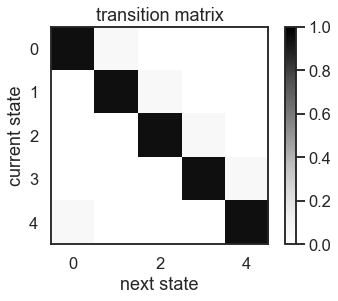

In [4]:
# Make a transition matrix
num_states = 5
transition_probs = (np.arange(num_states)**10).astype(float)
transition_probs /= transition_probs.sum()
transition_matrix = np.zeros((num_states, num_states))
for k, p in enumerate(transition_probs[::-1]):
    transition_matrix += np.roll(p * np.eye(num_states), k, axis=1)
    
plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
plt.xlabel("next state")
plt.ylabel("current state")
plt.title("transition matrix")
plt.colorbar()

In [5]:
# Make observation distributions
data_dim = 2
num_lags = 1

angles = np.linspace(0, 2 * np.pi, num_states, endpoint=False)
biases = np.column_stack([np.cos(angles), np.sin(angles)])
theta = np.pi / 25 # rotational frequency
keys = jr.split(jr.PRNGKey(0), num_states)
weights = [np.column_stack([0.8 * random_rotation(key, data_dim, theta=theta), bias])
           for key, bias in zip(keys, biases)]

observation_dists = [
    LinearAutoRegression(
        weights=weight,
        covariance_matrix=0.01**2 * np.eye(data_dim)
    )
    for key, weight in zip(keys, weights)
]

# Compute the stationary points
stationary_points = [
    np.linalg.solve(np.eye(data_dim) - dist.autoregression_weights[0], dist.bias)
    for dist in observation_dists
]

In [6]:
key = jr.PRNGKey(0)
tmp = 0.8 * random_rotation(key, data_dim, theta=np.pi / 25)
abs(np.linalg.eigvals(tmp))

DeviceArray([0.8000001, 0.8000001], dtype=float32)

# Plot dynamics functions

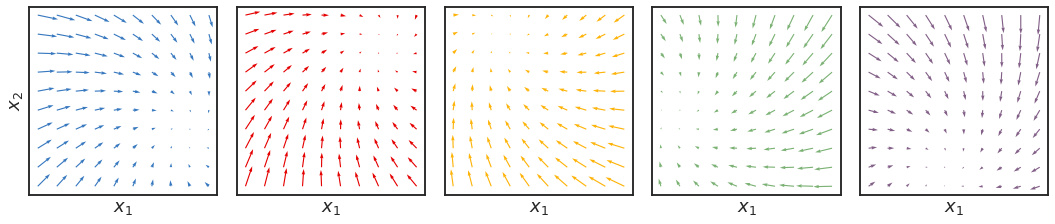

In [7]:
lim = 5
x = np.linspace(-lim, lim, 10)
y = np.linspace(-lim, lim, 10)
X, Y = np.meshgrid(x, y)
xy = np.column_stack((X.ravel(), Y.ravel()))

fig, axs = plt.subplots(1, num_states, figsize=(3 * num_states, 6))
for k, dist in enumerate(observation_dists):
    A, b = dist.autoregression_weights[0], dist.bias    
    dxydt_m = xy.dot(A.T) + b - xy
    axs[k].quiver(xy[:, 0], xy[:, 1],
                  dxydt_m[:, 0], dxydt_m[:, 1],
                  color=colors[k % len(colors)])

    
    axs[k].set_xlabel('$x_1$')
    axs[k].set_xticks([])
    if k == 0:
        axs[k].set_ylabel("$x_2$")
    axs[k].set_yticks([])
    axs[k].set_aspect("equal")
                    

plt.tight_layout()

# Sample data from the ARHMM

In [8]:
# Make an Autoregressive (AR) HMM
true_arhmm = ssm.AutoregressiveHMM(num_states, 
                                   num_lags,
                                   transitions=transition_matrix,
                                   observations=observation_dists,)
time_bins = 1000
prefix = (0, np.zeros(data_dim))
true_states, data = true_arhmm.sample(jr.PRNGKey(0), time_bins, prefix=prefix)

Text(0, 0.5, '$x_2$')

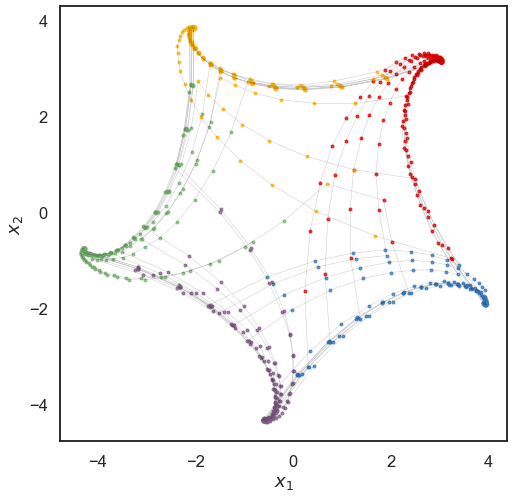

In [9]:
fig = plt.figure(figsize=(8, 8))
for k in range(num_states):
    plt.plot(*data[true_states==k].T, 'o', color=colors[k],
         alpha=0.75, markersize=3)
    
plt.plot(*data.T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
# plt.gca().set_aspect("equal")

Below, we visualize each component of of the observation variable as a time series. The colors correspond to the latent state. The dotted lines represent the stationary point of the the corresponding AR state while the solid lines are the actual observations sampled from the HMM.

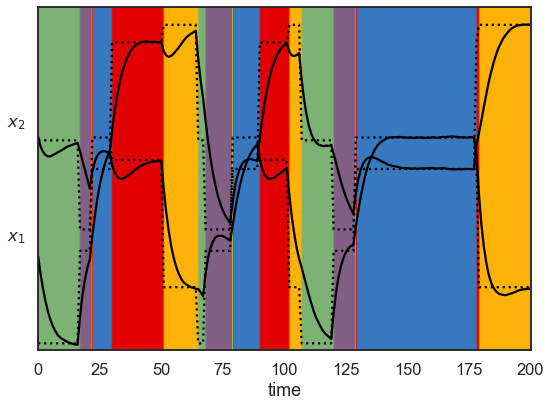

In [10]:
# Plot the data and the smoothed data
plot_slice = (0, 200)
lim = 1.05 * abs(data).max()
plt.figure(figsize=(8, 6))
plt.imshow(true_states[None, :],
           aspect="auto",
           cmap=cmap,
           vmin=0,
           vmax=len(colors)-1,
           extent=(0, time_bins, -lim, (data_dim)*lim))


Ey = np.array(stationary_points)[true_states]
for d in range(data_dim):
    plt.plot(data[:,d] + lim * d, '-k')
    plt.plot(Ey[:,d] + lim * d, ':k')

plt.xlim(plot_slice)
plt.xlabel("time")
plt.yticks(lim * np.arange(data_dim), ["$x_{}$".format(d+1) for d in range(data_dim)])

plt.tight_layout()


# Fit an ARHMM

In [11]:
## Now fit an HMM to the data
arhmm = ssm.HMM(num_states, transitions="standard", observations="auto_regression")
avg_log_probs, posterior = arhmm.fit(data, method="em", rng=jr.PRNGKey(1))
# avg_log_probs, posterior = arhmm.fit(data, method="em", num_iters=200)

Initializing...
Done.


IndexError: Array slice indices must have static start/stop/step to be used with NumPy indexing syntax. To index a statically sized array at a dynamic position, try lax.dynamic_slice/dynamic_update_slice (JAX does not support dynamically sized arrays within JIT compiled functions).

In [ ]:
# Plot the log likelihoods against the true likelihood, for comparison
true_avg_log_prob, true_posteriors = true_arhmm.average_log_prob(data)
plt.plot(avg_log_probs, label="EM")
plt.plot(true_avg_log_prob * np.ones(len(avg_log_probs)), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Find a permutation of the states that best matches the true and inferred states
most_likely_states = posterior.most_likely_states()
arhmm.permute(find_permutation(true_states, most_likely_states))
posterior.update()
most_likely_states = posterior.most_likely_states()

In [ ]:
lim = abs(data).max()
x = np.linspace(-lim, lim, 10)
y = np.linspace(-lim, lim, 10)
X, Y = np.meshgrid(x, y)
xy = np.column_stack((X.ravel(), Y.ravel()))

fig, axs = plt.subplots(2, num_states, figsize=(3 * num_states, 6))
for i, model in enumerate([true_arhmm, arhmm]):
    for j, dist in enumerate(model.observation_distributions):
        A, b = dist.autoregression_weights[0], dist.bias    
        dxydt_m = xy.dot(A.T) + b - xy
        axs[i,j].quiver(xy[:, 0], xy[:, 1],
                      dxydt_m[:, 0], dxydt_m[:, 1],
                      color=colors[j % len(colors)])


        axs[i,j].set_xlabel('$x_1$')
        axs[i,j].set_xticks([])
        if j == 0:
            axs[i,j].set_ylabel("$x_2$")
        axs[i,j].set_yticks([])
        axs[i,j].set_aspect("equal")
                    

plt.tight_layout()

In [ ]:
# Plot the true and inferred discrete states
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(true_states[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(most_likely_states[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

# Now fit with stochastic EM on minibatches of data

In [ ]:
num_batches = 4
batch_size = time_bins // num_batches
dataset = [dict(data=data[i * batch_size:(i+1) * batch_size])
           for i in range(num_batches)]

In [ ]:
arhmm = ssm.HMM(num_states, transitions="standard", observations="auto_regression")
avg_log_probs, posterior = arhmm.fit(dataset, method="stochastic_em", num_iters=200)

# Now try it on some real data!
<!-- ![](https://ars.els-cdn.com/content/image/1-s2.0-S0896627315010375-gr1.jpg)
_**Figure 1 of Wiltschko et al, 2015**: Depth Imaging Reveals Block Structure in 3D Mouse Pose Dynamics Data. (A) shows the raw RGB video and the depth video extracted from a Microsoft Kinect.  (B) shows a time series of raw pixels values of the rotated and aligned mouse, along with features of the mouse that suggest changes in pose over time.  (D) shows the trajectory in pixel space projected into the top two principal components of the images.  Stereotyped movements correspond to trajectories in this space._ 
-->

![](https://ars.els-cdn.com/content/image/1-s2.0-S0092867418305129-fx1.jpg)

**Graphical Abstract of Markowitz et al (2018).** 

We use a depth sensor to measure the time series of mouse posture in an open field (i.e. a bucket).  At the same time, we record neural activity in striatum with a microendoscope.  The goal is to relate this neural data to moment-by-moment mouse behavior, but in our to do so, we need some quantification of that behavior.  Following Wiltschko et al (2015), we rotate and align each frame of video so that the mouse is centered and facing right.  Then we perform PCA on the video frames to find a low-dimensional embedding of instantaneous mouse posture.   However, the cable coming out of the mouse's head poses a problem... it dominates the principal components.  Here we develop probabilistic methods to overcome this issue.

## References
Markowitz, J. E., Gillis, W. F., Beron, C. C., Neufeld, S. Q., Robertson, K., Bhagat, N. D., ... & Sabatini, B. L. (2018). The striatum organizes 3D behavior via moment-to-moment action selection. Cell, 174(1), 44-58.

Wiltschko, A. B., Johnson, M. J., Iurilli, G., Peterson, R. E., Katon, J. M., Pashkovski, S. L., ... & Datta, S. R. (2015). Mapping sub-second structure in mouse behavior. Neuron, 88(6), 1121-1135.


In [ ]:
import os
if not os.path.exists("pca_scores.h5"):
    !wget "https://www.dropbox.com/s/xzuhfh74t8kpk1c/pca_scores.h5"
    
if not os.path.exists("pca.h5"):
    !wget "https://www.dropbox.com/s/fru9gtkfn8wacwi/pca.h5"

In [ ]:
import h5py

# Load the principal components of the images
f_pca = h5py.File("pca.h5", "r")
image_shape = (80, 80)
full_mean_image = f_pca["mean"][()].reshape(image_shape)
full_components = f_pca["components"][()].reshape(-1, *image_shape)
explained_variance_ratio = f_pca['explained_variance_ratio'][()]

# crop the images to zoom in on the mouse
crop = (slice(20,  60), slice(10, 70))
mean_image = full_mean_image[crop]
components = full_components[(slice(-1),) + crop]

## Look at the principal components ("eigenmice")

In [ ]:
plt.imshow(mean_image)
plt.xticks([])
plt.yticks([])
plt.title("Mean Image")

In [ ]:
vlim = abs(components).max()
fig, axs = plt.subplots(8, 8, figsize=(12, 12))
for k, component in enumerate(components):
    row, col = k // 8, k % 8
    axs[row, col].imshow(component, vmin=-vlim, vmax=vlim, cmap="RdBu")
    axs[row, col].set_xticks([])
    axs[row, col].set_yticks([])
    
for k in range(len(components), 8 * 8):
    row, col = k // 8, k % 8
    axs[row, col].set_visible(False)
    
fig.suptitle("Principal Components", y=1.02)
plt.tight_layout()

In [ ]:
# Look at the explained variance ratio
plt.plot(np.cumsum(explained_variance_ratio), lw=3)
plt.hlines(0.95, 0, len(components) - 1, linestyle='--', color=colors[1])
plt.xlabel("num components")
plt.xlim(0, len(components) - 1)
plt.ylabel("% variance explained")
plt.ylim(plt.ylim()[0], 1)
plt.grid()

Based on the scree plot, it looks like 10 components might suffice

In [ ]:
num_components = 10

## Plot the principal component loadings over time

In [ ]:
# Extract data into properly formatted dataset
f_scores = h5py.File("pca_scores.h5", "r")
mouse_ids = [k for k in f_scores['metadata'].keys()]
dataset = []
for mouse in mouse_ids:
    dataset.append(dict(
        data=f_scores['scores'][mouse][:, :num_components],
        name=mouse)
    )

In [ ]:
# Look at lengths of each recording
from ssm.util import num_datapoints
for i, batch in enumerate(dataset):
    print("Batch {:2d}: Length {:d}".format(i, batch['data'].shape[0]))
print("Total length: ", num_datapoints(dataset))

In [ ]:
# Interpolate NaNs
from scipy.interpolate import interp1d
from scipy.stats import zscore
for batch in dataset:
    data = batch['data']
    batch['raw_data'] = data.copy()
    
    # Fill in NaNs
    for dim in range(num_components):
        valid = np.where(np.isfinite(data[:, dim]))[0]
        invalid = np.where(~np.isfinite(data[:, dim]))[0]
        f = interp1d(valid, data[valid, dim], fill_value="extrapolate")
        data[invalid, dim] = f(invalid)
    assert np.all(np.isfinite(data))
    
    # z-score
    data = zscore(data, axis=0)
    
    # Update dataset
    batch['data'] = data

In [ ]:
# Plot a slice of data
batch_idx = 0
sampling_rate = 30.0
plot_slice = (0, 60)  # in seconds
offsets = -10 * np.arange(num_components)

data = dataset[batch_idx]['data']
times = np.arange(data.shape[0]) / sampling_rate
plt.plot(times, data + offsets)
plt.xlim(plot_slice)
plt.xlabel("time (sec)")
plt.yticks(offsets, np.arange(num_components))
plt.ylabel("component")

# Construct an ARHMM

In [ ]:
# Split the dataset into train, validation, and test
train_len = 30000
valid_len = 10000
train_dataset = [dict(data=batch["data"][:train_len],
                      raw_data=batch["raw_data"][:train_len])
                 for batch in dataset]
valid_dataset = [dict(data=batch["data"][train_len:train_len+valid_len],
                      raw_data=batch["raw_data"][train_len:train_len+valid_len])
                 for batch in dataset]
test_dataset =  [dict(data=batch["data"][train_len+valid_len:],
                     raw_data=batch["raw_data"][train_len+valid_len:])
                 for batch in dataset]

In [ ]:
## Now fit an HMM to the data
num_states = 25
arhmm = ssm.HMM(num_states, observations="auto_regression", 
                observation_kwargs=dict(num_lags=3))

avg_log_probs, posterior = arhmm.fit(train_dataset, 
                                     validation_dataset=valid_dataset, 
                                     method="stochastic_em", 
                                     num_iters=10)

In [ ]:
plt.imshow(arhmm.transition_matrix, cmap="Greys")
plt.xlabel("next state")
plt.ylabel("current state")
plt.title("Transition Matrix")
plt.colorbar()

In [ ]:
from ssm.hmm.posteriors import HMMPosterior
test_posteriors = [HMMPosterior(arhmm, data) for data in test_dataset]
test_states = [p.most_likely_states() for p in test_posteriors]

In [ ]:
# Plot the inferred latent state distribution for one test batch
test_idx = 0
test_time_bins = len(test_dataset[test_idx]["data"])

plt.figure(figsize=(12, 8))
plt.imshow(test_posteriors[0].expected_states().T, 
           aspect="auto", extent=(0, test_time_bins / sampling_rate, num_states, 0))
plt.xlim(0, 180)
plt.xlabel("time (sec)")
plt.ylabel("discrete state")
plt.colorbar()

In [ ]:
# Sort states by usage
usage = sum(np.bincount(states, minlength=num_states) for states in test_states)
perm = np.argsort(usage)[::-1]
plt.bar(np.arange(num_states), usage[perm])
plt.xlabel("sorted states")
plt.ylabel("usage")

# Make some "syllable" movies

In [ ]:
from matplotlib import animation, rc
from matplotlib.cm import get_cmap
from IPython.display import HTML
from tqdm.auto import tqdm, trange

def make_movie(image_stack, frame_start=0, frame_stop=-1, title=None,
               figsize=(8, 8), cmap="cubehelix", nan_color="red",
               vmin=None, vmax=None):
    """
    Helper function to make an HTML animation of a sequence of video frames.
    """
    
    # Extract the segment of the image stack
    images = image_stack[frame_start:frame_stop]

    # Prepare the figure
    fig = plt.figure(figsize=figsize)
    ax1 = plt.axes((0, 0, 1, 1))
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    # Plot the image with nan's in a different color
    cmap = get_cmap(cmap)
    cmap.set_bad(color=nan_color)
    vmin = np.nanmin(images)
    vmax = np.nanmax(images)
    
    # Initialize the image
    im = ax1.imshow(images[0, :, :], vmin=vmin, vmax=vmax, cmap=cmap)

    # Show the title
    if title is not None:
         ax1.text(0.5, 0.9, title,
                  color="white", 
                  fontsize=14,
                  horizontalalignment="center",
                  transform=ax1.transAxes)
    
    # Show the counter
    counter = ax1.text(0.9, 0.95, "Frame 0", 
                     color="white", 
                     fontsize=12,
                     horizontalalignment="left",
                     transform=ax1.transAxes)
    counter.set_color("white")
    
    # Progress bar for making the animation
    pbar = tqdm(total=images.shape[0], unit="frames")

    def init():
        return im, counter

    def animate(i):
        im.set_data(images[i, :, :])
        counter.set_text("Frame {}".format(i))
        pbar.update(1)
        return im, counter

    # Call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, 
                                   animate, 
                                   init_func=init,
                                   frames=images.shape[0], 
                                   interval=30, 
                                   blit=True)
    html = HTML(anim.to_html5_video())
    plt.close(fig)
    return html

In [ ]:
def make_syllable_image_stacks(state_idx, test_states, test_dataset, mean_image, components,
                               grid_shape=(5, 5),
                               min_duration=3,
                               pad=30,
                               draw_square=True,
                               ):
    # Find all the start indices and durations of specified state
    all_mouse_inds = []
    all_starts = []
    all_durations = []
    for mouse, (states, data_dict) in enumerate(zip(test_states, test_dataset)):
        states = np.concatenate([[-1], states, [-1]])
        starts = np.where((states[1:] == state_idx) & (states[:-1] != state_idx))[0]
        
        stops = np.where((states[:-1] == state_idx) & (states[1:] != state_idx))[0]
        
        durations = stops - starts
        assert np.all(durations >= 1)
        all_mouse_inds.append(mouse * np.ones(len(starts), dtype=int))
        all_starts.append(starts)
        all_durations.append(durations)
    
    all_mouse_inds = np.concatenate(all_mouse_inds)
    all_starts = np.concatenate(all_starts)
    all_durations = np.concatenate(all_durations)

    # Throw away ones that are too short or too close to start.
    # TODO: also throw away ones close to the end
    valid = (all_durations > min_duration) & (all_starts > pad) & (all_starts + all_durations < 10000)
            
    num_valid = np.sum(valid)
    all_mouse_inds = all_mouse_inds[valid]
    all_starts = all_starts[valid]
    all_durations = all_durations[valid]

    # Choose a random subset to show
    num_instances = np.prod(grid_shape)
    subset = npr.choice(num_valid, size=min(num_valid, num_instances), replace=False)
    max_duration = np.max(all_durations[subset])
    
    # Reconstruct the image from the PCs
    image_shape = components.shape[1:]
    image_stack = np.zeros((2 * pad + max_duration, 
                            grid_shape[0] * image_shape[0],
                            grid_shape[1] * image_shape[1]))
    
    for i, idx in enumerate(subset):
        mouse = all_mouse_inds[idx]
        start = all_starts[idx]
        duration = all_durations[idx]
        
        pcs = test_dataset[mouse]["raw_data"][start-pad:start-pad+max_duration+2*pad]
        
        row = i // grid_shape[1]
        col = i % grid_shape[1]
        top = row * image_shape[0]
        left = col * image_shape[1]
        
        image_stack[:len(pcs), top:top+image_shape[0], left:left+image_shape[1]] = \
            mean_image + np.einsum('td,dij->tij', pcs, components)
        
        if draw_square:
            image_stack[pad:pad+duration, top:top+5, left:left+5] = np.nan
    
    return image_stack

In [ ]:
def show_syllable(rank):
    image_stack = make_syllable_image_stacks(perm[rank],
                                             test_states, 
                                             test_dataset, 
                                             mean_image, 
                                             components[:num_components])

    # image_stack.shape
    return make_movie(image_stack, title="Syllable {}".format(rank))

In [ ]:
show_syllable(0)

In [ ]:
show_syllable(1)

In [ ]:
show_syllable(2)

In [ ]:
show_syllable(3)

In [ ]:
show_syllable(4)

In [ ]:
show_syllable(5)

In [ ]:
show_syllable(6)

In [ ]:
show_syllable(7)

In [ ]:
show_syllable(8)

In [ ]:
show_syllable(9)

In [ ]:
show_syllable(10)

In [ ]:
show_syllable(11)

In [ ]:
show_syllable(12)

In [ ]:
show_syllable(13)

In [ ]:
show_syllable(14)

In [ ]:
show_syllable(15)

In [ ]:
show_syllable(16)

In [ ]:
show_syllable(17)

In [ ]:
show_syllable(18)

In [ ]:
show_syllable(19)

In [ ]:
show_syllable(20)

In [ ]:
show_syllable(21)

In [ ]:
show_syllable(22)